In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cvxpy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
import scipy as sp


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
import pandas as pd

In [14]:
Sigma, causal_snps, tissue_membership, causal = pickle.load(open('../simulation_scripts/T10_simulation', 'rb'))
T, N = causal.shape

effectsize = 8

Sigma_reg = (Sigma + np.eye(N)*1e-6) / (1+1e-6)
chol = np.linalg.cholesky(Sigma_reg)
Y = (effectsize * Sigma @ causal.T + chol @ np.random.normal(size=causal.T.shape)).T
X = Sigma_reg

In [15]:
output_dir='output/mixed_ser'
name = 'test'

In [7]:
from spike_and_slab_ser import *

In [8]:
def get_inputs(zscore_path, ld_path, gene):
    X = pd.read_csv(ld_path + gene, index_col=0)
    zscores = pd.read_csv(zscore_path + gene + '.zscore_matrix.txt', '\t', index_col=0)

    nan_snps = np.all(np.isnan(X.values), axis=1)
    X = X.iloc[~nan_snps].iloc[:, ~nan_snps]

    active_snps = np.isin(X.index, zscores.index)
    X = X.iloc[active_snps].iloc[:, active_snps]

    active_snps = np.isin(zscores.index, X.index)
    Y = zscores.iloc[active_snps]
    Y = Y.iloc[:, ~np.any(np.isnan(Y.values), 0)]
    

    tissues = Y.columns.values
    snp_ids = Y.index.values
    pos = np.array([int(snp_id.split('_')[1]) for snp_id in snp_ids])

    Y = Y.T.values
    X = X.values
    X = (X + np.eye(X.shape[0])*1e-6) / (1+1e-6)
    
    return X, Y, tissues, snp_ids

In [18]:
gene = 'ENSG00000073464.11'
gene = 'ENSG00000141644.17'
gene = 'ENSG00000164904.17'

In [19]:
ld_path = '../marios_correlation_matrices/'
zscoore_path = '../data/zscore_genes_for_Karl/'

X, Y, tissues, snp_ids = get_inputs(zscoore_path, ld_path, gene)

T, N = Y.shape

## Spike and slab

iter 0 outer loop elbo: 0, max_weight_diff: 4.621821589490391


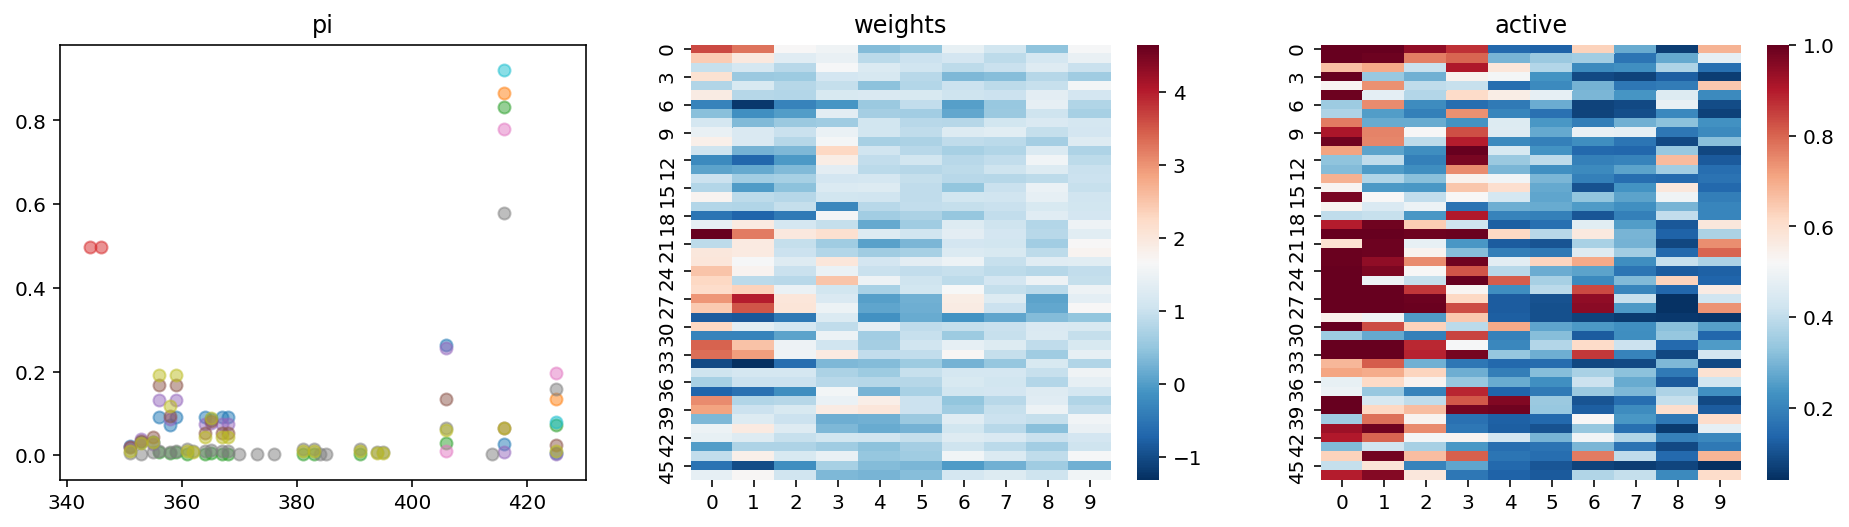

iter 10 outer loop elbo: 0, max_weight_diff: 0.061433593403935505


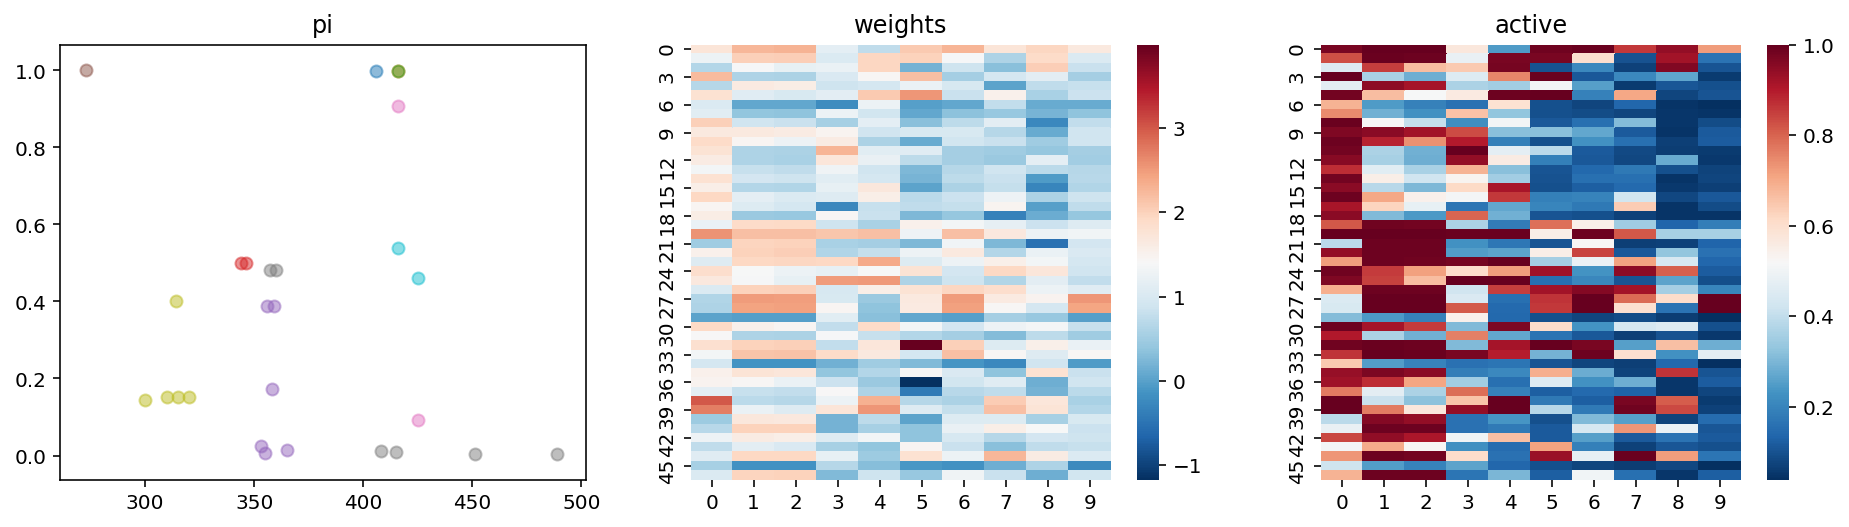

iter 20 outer loop elbo: 0, max_weight_diff: 0.003745031127070586


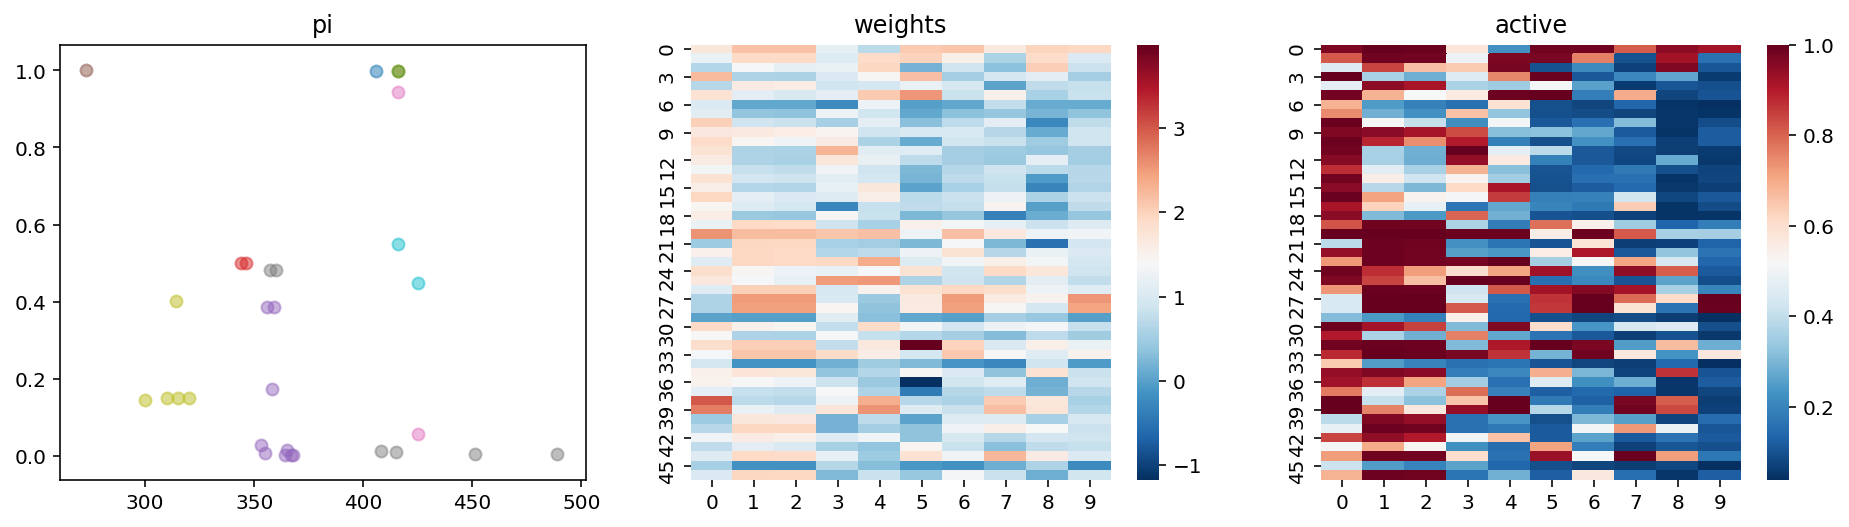

iter 30 outer loop elbo: 0, max_weight_diff: 0.0008409832892996016


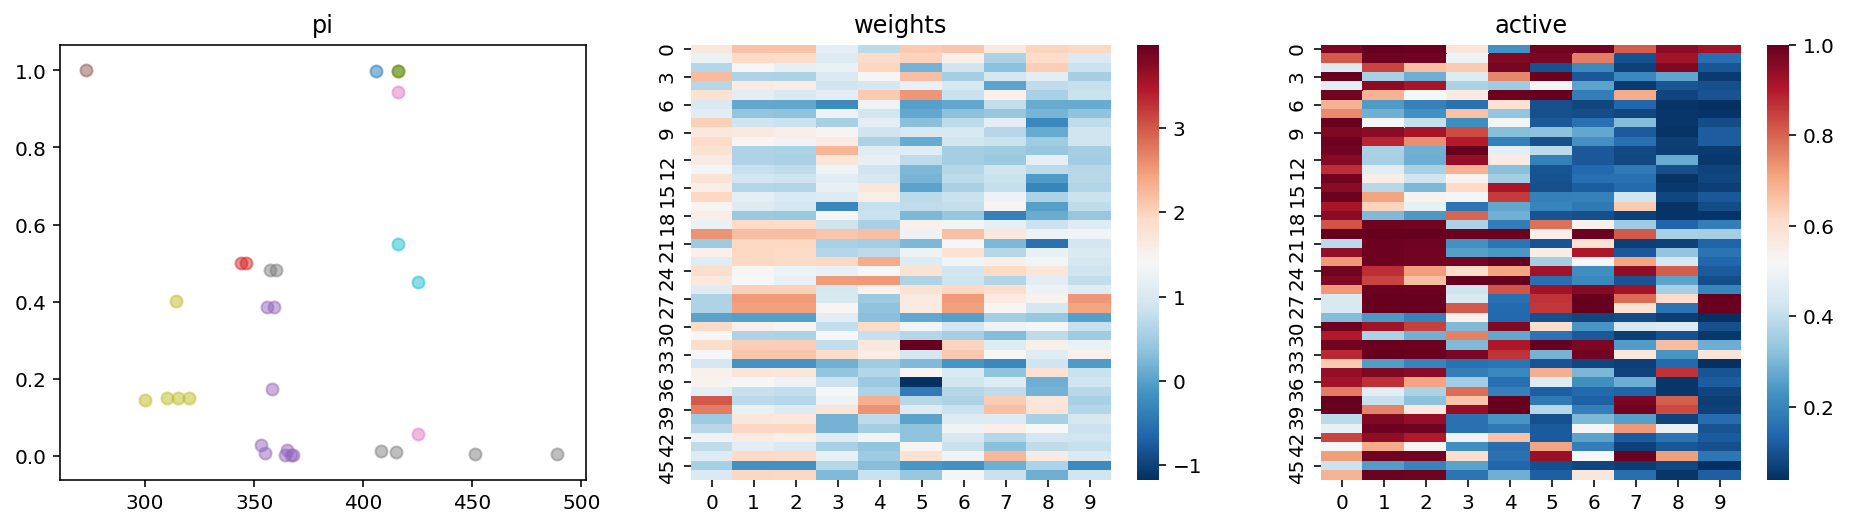

In [ ]:
#######################
# set hyperparameters #
#######################
maxiter = 200
K = 10
prior_activity = np.exp(-1*np.linspace(1, 3, K))
prior_variance = 1.0


#######################################
# initialize (variational) parameters #
#######################################
pi = np.random.random((N, K)) + 1
pi = pi / pi.sum(0)

weights = np.random.random((T, K)) * 1
active = np.log(np.ones((T, K)))

# problem, param_dict = make_problem(N, K, True)

#########################
# make mvn distribution #
#########################

#dist = multivariate_normal(cov=X)
#chol = np.linalg.cholesky(X)


# make save paths
convergence_status = False

for i in range(maxiter):
    # update pi and beta
    for j in range(100):
        diff = update_pi(X, Y, weights, active, pi)

        # exit inner loop if we converged
        if diff < 1e-8:
            # enter a new outer loop, need this?
            convergence_status = False
            break

    # update weights
    diff = update_ss_weights(X, Y, weights, active, pi, prior_activity, prior_variance)
    
    if i % 10 == 0:
        print('iter {} outer loop elbo: {}, max_weight_diff: {}'.format(
            i, (0), diff))

        W = weights * np.exp(active)
        # make plot
        active_components = np.exp(active).max(0) > 1e-3
        if np.all(~active_components):
            active_components[:3] = True

        fig, ax = plt.subplots(1, 3, figsize=(16, 4))
        for k in np.arange(K)[active_components]:
            ax[0].scatter(np.arange(N)[pi[:, k] > 2/N], pi[:, k][pi[:, k] > 2/N], alpha=0.5)
        ax[0].set_title('pi')

        sns.heatmap(weights[:, active_components], annot=False, cmap='RdBu_r', ax=ax[1])
        ax[1].set_title('weights')
        
        sns.heatmap(np.exp(active)[:, active_components], annot=False, cmap='RdBu_r', ax=ax[2])
        ax[2].set_title('active')


        plt.show()
        plt.close()

    if diff < 1e-8:
        print('weight parameter converged')
        convergence_status = True
        break

In [ ]:
old_active = active.copy()
old_weights = weights.copy()

diff = update_ss_weights(X, Y, weights, active, pi, prior_activity, prior_variance=1.0)

fig, ax = plt.subplots(1, 2)
sns.heatmap(old_weights, cmap='RdBu_r', ax=ax[0])
sns.heatmap(weights, cmap='RdBu_r', ax=ax[1])
plt.show()

In [ ]:
old_active = active.copy()
old_weights = weights.copy()

diff = update_ss_weights(X, Y, weights, active, pi, prior_activity, prior_variance=1.0)

fig, ax = plt.subplots(1, 2)
sns.heatmap(np.exp(old_active), cmap='RdBu_r', ax=ax[0])
sns.heatmap(np.exp(active), cmap='RdBu_r', ax=ax[1])
plt.show()

In [ ]:
for i in range(K):
    plt.scatter(np.arange(N), pi[:, i])
    plt.show()

In [ ]:
for t in range(T):
    plt.scatter(old_weights[t], weights[t])

In [ ]:
(np.exp(old_active) - np.exp(active)).max()

In [ ]:
np.arange(K)[active_components]

In [ ]:
np.all(~active_components):
    active_components[0] = True

In [ ]:
W = weights * np.exp(active)
pred = W @ (X @ pi).T

In [ ]:
fig, ax = plt.subplots(1, T, figsize=(4*T, 3), sharey=True)
for t in range(T):
    ax[t].scatter(np.arange(N), Y[t], c='k', marker='x', alpha=0.5)
    ax[t].scatter(np.arange(N), pred[t], c='r', marker='o', alpha=0.5)
    #ax[t].set_title(tissues[t])
    ax[t].set_xlabel('position')
ax[0].set_ylabel('zscore')
plt.show()

fig, ax = plt.subplots(1, T, figsize=(4*T, 3), sharex=True, sharey=True)
for t in range(T):
    ax[t].scatter(pred[t], Y[t], c='k', marker='x', alpha=0.5)
    ax[t].set_title('Tissue {}'.format(t))
    ax[t].set_xlabel('prediction')
ax[0].set_ylabel('zscore')
plt.show()

In [ ]:
p = np.exp(active)

In [ ]:
sns.heatmap(p, cmap='RdBu_r')

In [ ]:
colocalization_prob = np.zeros((T, T))
from itertools import product

for t1 in range(T):
    for t2 in range(T):
        p1 = p[t1]
        p2 = p[t2]
        colocalization_prob[t1, t2] = 1 - np.exp(np.sum(np.log(1 + 1e-10 - p1 * p2)))

In [ ]:
sns.heatmap(colocalization_prob, yticklabels=tissues, xticklabels=tissues)

In [ ]:
save_dict = {
    'pi': pi,
    'active': active,
    'weights', weights,
    'prior_activity': prior_activity,
    'prior_variance': prior_variance,
    'K': K,
    'N': Y.shape[1],
    'T': Y.shape[0],
    'gene': gene,
    'converged': convergence_status,
    'snp_ids': snp_ids,
    'tissues': tissues
}

In [ ]:
L = 12
np.exp(-np.linspace(1, 10, L))

In [ ]:
L = 12
prior_activity = np.exp(-1*((np.arange(L) / L) + 5))
prior_activity

In [ ]:
p = np.exp(active)

In [ ]:
def colocalization_probability(t1, t2, active):
    

In [ ]:
p1 = p[0]
p2 = p[1]

In [ ]:
p1 * p2

In [ ]:
W = active_weight_means * active

In [ ]:
bound = np.einsum('ij,ji->i', (Y @ pi), W.T).sum()

In [ ]:
K = pi.shape[1]
Kzz = np.zeros((K, K))
for i in range(K):
    for j in range(K):
        pi1 = pi[:, i]
        pi2 = pi[:, j]
        Kzz[i, j] = np.sum(np.outer(pi1, pi2) * X)

Kzz = Kzz + np.diag(np.ones(K) - np.diag(Kzz))

for t in range(T):
    bound += -0.5 * W[t] @ Kzz @ W[t]

In [ ]:
bound

In [ ]:
Y[0] @ pi @ W[0]

In [ ]:
W = active_weight_means * active
W.shape

In [ ]:
sns.heatmap(active)

In [ ]:
on = r_k @ pi[:, k] * active_weight_means[:, k] \
    - 0.5 * (active_weight_means[:, k]**2 + active_weight_vars[:, k]) + np.log(prior_activity[k])

normalizer = np.log(np.exp(on) + (1-prior_activity[k]))
logp = on - normalizer

In [ ]:
np.exp(logp)

In [ ]:
(np.exp(on - normalizer) + np.exp(off - normalizer))

In [ ]:
off

In [ ]:
new_active_mean = r_k

In [ ]:
pi1 = pi[:, 0]
pi2 = pi[:, 1]

In [ ]:
Kzz = np.zeros((K, K))
for i in range(K):
    for j in range(K):
        pi1 = pi[:, i]
        pi2 = pi[:, j]
        Kzz[i, j] = np.sum(np.outer(pi1, pi2) * X)
        
Kzz = Kzz + np.diag(np.ones(K) - np.diag(Kzz))

In [ ]:
def quad1(a, B):
    

In [ ]:
sns.heatmap(Kzz, annot=True)

In [ ]:
Kzz2 = (X @ pi)
Kzz2 = Kzz2.T @ Kzz2
sns.heatmap(Kzz2, annot=True)

In [ ]:
(X[None] * pi.T[..., None]).shape

In [ ]:
sns.heatmap(Kzz - Kzz2, annot=True)

In [ ]:
sns.heatmap((X @ pi).T @ (X @ pi), annot=True)

In [ ]:
np.diag(pi.T @ pi)

In [ ]:
pred = (weights * beta_means) @ (X @ pi).T
pred.shape, pred.max()

In [ ]:
fig, ax = plt.subplots(1, T, figsize=(4*T, 3), sharey=True)
for t in range(T):
    ax[t].scatter(np.arange(N), Y[t], c='k', marker='x', alpha=0.5)
    ax[t].scatter(np.arange(N), pred[t], c='r', marker='o', alpha=0.5)
    #ax[t].set_title(tissues[t])
    ax[t].set_xlabel('position')
ax[0].set_ylabel('zscore')
plt.show()

fig, ax = plt.subplots(1, T, figsize=(4*T, 3), sharex=True, sharey=True)
for t in range(T):
    ax[t].scatter(pred[t], Y[t], c='k', marker='x', alpha=0.5)
    ax[t].set_title('Tissue {}'.format(t))
    ax[t].set_xlabel('prediction')
ax[0].set_ylabel('zscore')
plt.show()

In [ ]:
plt.plot(elbos)

In [ ]:
fig, ax = plt.subplots(1, active.sum(), figsize=(4*active.sum(), 3))
for i, k in enumerate(np.arange(K)[active]):
    ax[i].scatter(np.arange(N), pi[:, k], marker='x', c='k')
    ax[i].scatter(causal_snps, pi[causal_snps, k], marker='o', c='r')
plt.show()

In [ ]:
pi

In [ ]:
# set up problem
K = 12
pi = np.random.random((N, K))
pi = pi / pi.sum(0)

beta_means = np.random.random(K)
beta_vars = np.ones(K)
weights = np.random.random((T, K)) + 1
#weights = causal[:, causal_snps]

# make optimization problem
problem, param_dict = make_problem(N, K, True)

# make mvn distribution
dist = multivariate_normal(cov=Sigma_reg)
chol = np.linalg.cholesky(Sigma_reg)

In [ ]:
sns.heatmap(weights, annot=True, cmap='Blues')

In [ ]:
penalty = 3.0
outer_elbos = [compute_elbo(Y, pi, beta_means, beta_vars, weights, dist, penalty=1)]
inner_elbos = [outer_elbos[0]]
maxiter = 50
max_restart = 10

# initialize without l1 penalty
for i in range(maxiter):
    # restart components if its early in optimization
    if i < max_restart:
        not_active = np.abs(weights).max(0) < 1e-6
        if not_active.sum() > 0:
            print('restarting componenents {}'.format(not_active))

            restart_freq = (1 / (pi.sum(1) + 0.01))
            restart_freq = restart_freq / restart_freq.sum()
            for c in np.arange(K)[not_active]:
                pi[:, c] = restart_freq
                weights[:, c] = (np.random.random(T) + 1)
                beta_means[c] = 1.0
                beta_vars[c] = 1.0

    print('update variational params')
    for j in range(100):        
        # iteratively update each component
        pi_old = pi.copy()
        for k in range(K):
            # if component is being used, update
            if np.abs(weights[:, k]).max() > 1e-5:
                update_pi(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k)
                update_beta(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k, chol)
                 
        # compute elbo to test convergence
        inner_elbos.append(compute_elbo(Y, pi, beta_means, beta_vars, weights, dist, penalty=1))

        # exit loop if we converged
        #print('\tinner loop elbo: {}'.format((inner_elbos[-1] - inner_elbos[-2])))
        print('\tmax pi diff: {}'.format(np.abs(pi - pi_old).max()))
        if np.abs(inner_elbos[-1] - inner_elbos[-2]) < 1e-5:
            break

    # update weights
    print('updating weights')
    set_params(pi, beta_means, beta_vars, Sigma_reg, penalty, param_dict)
    
    old_weights = weights.copy()
    weights = np.array([solve_w_tissue(Yt, param_dict, problem) for Yt in Y])
    
    outer_elbos.append(compute_elbo(Y, pi, beta_means, beta_vars, weights, dist, penalty=1))
    inner_elbos.append(outer_elbos[-1])

    # exit loop if we converged
    print('outer loop elbo: {}'.format((outer_elbos[-1] - outer_elbos[-2])))
    print('outer loop weight diff: {}'.format(np.mean(np.square(weights - old_weights))))

    # make plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for k in range(K):
        ax[0].scatter(np.arange(N), pi[:, k], alpha=0.5)
    ax[0].scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')

    active = np.abs(weights).max(0) > 1e-6
    sns.heatmap(weights[:, active], annot=True, cmap='RdBu_r', ax=ax[1])
    plt.show()
    
    if np.abs(outer_elbos[-1] - outer_elbos[-2]) < 1e-5:
        break

In [ ]:
update_pi(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k)

In [ ]:
r = Y - (beta_means * weights) @ (Sigma @ pi).T

# remove effect of kth component from residual
r_k = r + ((beta_means[k] * weights[:, k])[:, None] * (Sigma @ pi[:, k])[None])

# get relevant pi
pi_k = pi[:, k]

# now update beta with new pi
beta_vars_a = 1 / (1 + np.sum(weights[:, k]**2))
beta_means_a = (beta_vars_a) * \
    (Sigma * pi_k).sum(1) @ solve_cholesky(chol, (r_k * weights[:, k][:, None]).sum(0))

In [ ]:
for k in range(K):
    a = (Sigma * pi_k).sum(1) @ solve_cholesky(chol, (r_k * weights[:, k][:, None]).sum(0))
    b = np.inner(pi_k, (r_k * weights[:, k][:, None]).sum(0))
    print(np.isclose(a, b), a, b)

In [ ]:
pi_k, (r_k * weights[:, k][:, None])

In [ ]:
# compute residual
r = Y - (beta_means * weights) @ (Sigma_reg @ pi).T

# remove effect of kth component from residual
r_k = r + ((beta_means[k] * weights[:, k])[:, None] * (Sigma_reg @ pi[:, k])[None])

pi_k = r_k * weights[:, k][:, None] * beta_means[k]
pi_k = pi_k.sum(0)

# compute_likehood under each inducing point
#pi_k = np.array(
#    [dist.logpdf(r_k - (beta_means[k] * weights[:, k])[:, None] * Sigma[i][None]).sum() for i in range(N)])

# normalize to probabilities
pi_k = np.exp(pi_k - pi_k.min())
#pi_k = pi_k / pi_k.sum()

In [ ]:
r

In [ ]:
beta_means[6], beta_vars[6]

In [ ]:
pi[:, 6]

In [ ]:
# make plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for k in range(K):
    ax[0].scatter(np.arange(N), pi[:, k], alpha=0.5)
ax[0].scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')

sns.heatmap(weights, annot=True, cmap='RdBu_r', ax=ax[1])
plt.show()

In [ ]:
penalty = 5.0
outer_elbos = [compute_elbo(Y, pi, beta_means, beta_vars, weights, dist, penalty=1)]
inner_elbos = [outer_elbos[0]]
maxiter = 20

# initialize without l1 penalty
for i in range(maxiter):
    # update SER models
    print('update variational params')
    for j in range(100):        
        # iteratively update each component
        for k in range(K):
            # if component is being used, update
            if np.abs(weights[:, k]).max() > 1e-5:
                update_pi(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k, chol)
                update_beta(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k, chol)
                
        # compute elbo to test convergence
        inner_elbos.append(compute_elbo(Y, pi, beta_means, beta_vars, weights, dist, penalty=1))

        # exit loop if we converged
        print('inner loop elbo diff: {}'.format((inner_elbos[-1] - inner_elbos[-2])))
        if np.abs(inner_elbos[-1] - inner_elbos[-2]) < 1e-5:
            break

    # update weights
    print('updating weights')
    set_params(pi, beta_means, beta_vars, Sigma_reg, penalty, param_dict)
    weights = np.array([solve_w_tissue(Yt, param_dict, problem) for Yt in Y])
    
    outer_elbos.append(compute_elbo(Y, pi, beta_means, beta_vars, weights, dist, penalty=1))
    inner_elbos.append(outer_elbos[-1])

    # exit loop if we converged
    print('outer loop elbo diff: {}'.format((outer_elbos[-1] - outer_elbos[-2])))
    if np.abs(outer_elbos[-1] - outer_elbos[-2]) < 1e-5:
        break
            
    # make plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for k in range(K):
        ax[0].scatter(np.arange(N), pi[:, k], alpha=0.5)
    ax[0].scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')
    
    sns.heatmap(weights, annot=True, cmap='RdBu_r', ax=ax[1])
    plt.show()

In [ ]:
    # make plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for k in range(K):
        ax[0].scatter(np.arange(N), pi[:, k], alpha=0.5)
    ax[0].scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')
    
    sns.heatmap(weights, annot=True, cmap='RdBu_r', ax=ax[1])
    plt.show()

In [ ]:
beta_vars

In [ ]:
plt.plot(np.arange(len(inner_elbos)), inner_elbos)

In [ ]:
# compute residual
r = Y - (beta_means * weights) @ (Sigma_reg @ pi).T

# remove effect of kth component from residual
r_k = r + ((beta_means[k] * weights[:, k])[:, None] * (Sigma_reg @ pi[:, k])[None])

# compute_likehood under each inducing point
pi_k = np.array(
    [dist.logpdf(r_k - (beta_means[k] * weights[:, k])[:, None] * Sigma_reg[i][None]).sum() for i in range(N)])

# normalize to probabilities
pi_k = np.exp(pi_k - pi_k.min())
pi_k = pi_k / pi_k.sum()
pi_k1 = pi_k

In [ ]:
plt.scatter(pi_k1, pi_k)

In [ ]:
r_k.shape, weights[:, k].shape, beta_means[k].shape

In [ ]:
-2 * np.sum(r_k * weights[:, k][:, None] * beta_means[k], axis=0)

In [ ]:
((Sigma * pi_k).sum(1) - (Sigma@pi)[:, 0]).min()

In [ ]:
(Sigma@pi)[:, 0]

In [ ]:
var_Kxz = (Sigma_reg * pi_k @ Sigma_reg) - \
    ((Sigma_reg * pi_k).sum(1) * (Sigma_reg * pi_k).sum(1)[:, None])

In [ ]:
np.trace(np.linalg.solve(Sigma_reg, var_Kxz))

In [ ]:
np.isclose(1e-7, 0)

In [ ]:
weights.shape

In [ ]:
penalty = 10.0

# remove component
for i in range(5):
    # update SER models
    for j in range(5):
        for k in range(K):
            # if component is being used, update
            if ~np.isclose(np.abs(weights[:, k]).max(), 0):
                ser_mvn(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k, chol)

            elbos.append(compute_elbo(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, penalty=penalty))
            print('outer_iter {}, inner_iter {}, component {}:, {}'.format(i, j, k, elbos[-1]))

    # update weights
    print('updating weights')
    set_params(pi, beta_means, beta_vars, Sigma_reg, penalty, param_dict)
    weights = np.array([solve_w_tissue(Yt, param_dict, problem) for Yt in Y])
    
    for k in range(K):
        plt.scatter(np.arange(N), pi[:, k], alpha=0.5)
    plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')
    plt.show()
    
    sns.heatmap(weights, annot=True, cmap='RdBu_r')
    plt.show()

In [ ]:
# remove component
for i in range(10):
    # update SER models
    for j in range(1):
        for k in range(K):
            print('outer_iter {}, inner_iter {}, component {}'.format(i, j, k))
            ser_mvn(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k, chol)

    # update weights
    print('updating weights')
    set_params(pi, beta_means, beta_vars, Sigma_reg, 10.0, param_dict)
    weights = np.array([solve_w_tissue(Yt, param_dict, problem) for Yt in Y])
    
    for k in range(K):
        plt.scatter(np.arange(N), pi[:, k], alpha=0.5)
    plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')
    plt.show()
    
    vmax = np.max(np.abs(weights))
    vmin = -vmax
    sns.heatmap(weights, annot=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.show()

In [ ]:
# remove component
# update weights
print('updating weights')
set_params(pi, beta_means, beta_vars, Sigma_reg, 40.0, param_dict)
weights = np.array([solve_w_tissue(Yt, param_dict, problem) for Yt in Y])

vmax = np.max(np.abs(weights))
vmin = -vmax
sns.heatmap(weights, annot=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
for j in range(5):
    for k in range(K):
        print('outer_iter {}, inner_iter {}, component {}'.format(i, j, k))
        ser_mvn(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k, chol)

In [ ]:
reconstruction = ((Sigma @ pi) @ (beta_means * weights).T)

fig, ax = plt.subplots(1, T, figsize=(4*T, 3), sharex=True, sharey=True)
for t in range(T):
    ax[t].scatter(reconstruction[:, t], Y[t], alpha=0.1, marker='x', c='k')
    ax[t].scatter(reconstruction[:, t][causal[t] > 0], Y[t][causal[t] > 0], marker='*', c='r', s=100)
    ax[t].set_title('Tissue {}'.format(t))

In [ ]:
reconstruction = ((Sigma @ pi) @ (beta_means * weights).T)

fig, ax = plt.subplots(1, T, figsize=(4*T, 3), sharex=True, sharey=True)
for t in range(T):
    ax[t].scatter(np.arange(N), np.square(reconstruction[:, t] - Y[t]), alpha=0.1, marker='x', c='k')
    ax[t].scatter(np.arange(N)[causal[t] > 0], np.square(reconstruction[:, t][causal[t] > 0] - Y[t][causal[t] > 0]), marker='*', c='r', s=100)
    ax[t].set_title('Tissue {}, SE'.format(t))

In [ ]:
causal.shape

In [ ]:
#pi = T10_5_simulation_param_dict['pi']

fig, ax = plt.subplots(1, figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
for k in range(K):
    plt.scatter(np.arange(N)[pi[:, k] > 2/N],
                pi[:, k][pi[:, k] > 2/N], alpha=0.5, marker='x', c=colors[k])
    plt.scatter(causal_snps[pi[causal_snps, k] > 2/N],
                pi[causal_snps, k][pi[causal_snps, k] > 2/N], alpha=0.5, marker='o', c=colors[k], s=200)


#plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='*', c='k', s=100)
plt.xlabel('SNP')
plt.ylabel('Probability of being inducing point')
plt.show()

In [ ]:
#pi = T10_5_simulation_param_dict['pi']

fig, ax = plt.subplots(1, figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
for k in range(4):
    plt.scatter(np.arange(N) * ~np.isclose(pi[:, k], 0) ,
                pi[:, k] * ~np.isclose(pi[:, k], 0), alpha=0.5, marker='x', c=colors[k])
    plt.scatter(causal_snps[~np.isclose(pi[causal_snps, k], 0)],
                pi[causal_snps, k][~np.isclose(pi[causal_snps, k], 0)], alpha=0.5, marker='o', c=colors[k], s=200)


#plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='*', c='k', s=100)
plt.xlabel('SNP')
plt.ylabel('Probability of being inducing point')
plt.show()

In [ ]:
reconstruction = ((Sigma @ pi) @ (beta_means * weights).T)
reconstruction.shape

In [ ]:
T10_5_simulation_param_dict = {
    'weights': weights,
    'beta_means': beta_means,
    'beta_vars': beta_vars,
    'pi': pi
}

In [ ]:
sns.heatmap(weights, annot=True, cmap='Blues')
plt.show()

In [ ]:
problem, param_dict = make_problem(N, K)

In [ ]:
problem

In [ ]:
#pi = T10_5_simulation_param_dict['pi']

fig, ax = plt.subplots(1, figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
for k in range(4):
    plt.scatter(np.arange(N) * ~np.isclose(pi[:, k], 0) ,
                pi[:, k] * ~np.isclose(pi[:, k], 0), alpha=0.5, marker='x', c=colors[k])
    plt.scatter(causal_snps[~np.isclose(pi[causal_snps, k], 0)],
                pi[causal_snps, k][~np.isclose(pi[causal_snps, k], 0)], alpha=0.5, marker='o', c=colors[k], s=200)


#plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='*', c='k', s=100)
plt.xlabel('SNP')
plt.ylabel('Probability of being inducing point')
plt.show()

### Without sharing

In [ ]:
# set up problem
K = 3

pi_tissue = np.random.random((N, K))
pi_tissue = pi / pi.sum(0)

tissue_beta_means = np.random.random((K))
tissue_beta_vars = np.ones((K))

# make mvn distribution
dist = multivariate_normal(cov=Sigma_reg)
chol = np.linalg.cholesky(Sigma_reg)

tissue_weights = np.ones((1, K))

In [ ]:
problem, param_dict = make_problem(N, K)

In [ ]:
tissues = [0]
t = 0
for i in range(10):
    # update SER models
    for k in range(K):
        print('tissue {}, iter {}, component {}'.format(t, i, k))
        ser_mvn(
            Y[tissues], pi_tissue,
            tissue_beta_means, tissue_beta_vars,
            tissue_weights, Sigma_reg, dist, k, chol)

    # update weights
    set_params(pi_tissue, tissue_beta_means, tissue_beta_vars, Sigma_reg, 0.1, param_dict)
    tissue_weights = solve_w_tissue(Y[t], param_dict, problem)[None]
    
    print(tissue_beta_means, tissue_beta_vars)
    print(tissue_weights)
    for k in range(K):
        plt.scatter(np.arange(N), pi_tissue[:, k], alpha=0.5, marker='x')
    plt.show()

In [ ]:
plt.scatter(np.arange(N), pi_tissue[:, 1], alpha=0.5, marker='x')
#plt.scatter(np.arange(N), pi_tissue[:, 1], alpha=0.5, marker='x')
#plt.scatter(np.arange(N), pi_tissue[:, 2], alpha=0.5, marker='x')



plt.show()

In [ ]:
ser_mvn(Y, pi, beta_means, beta_vars, weights, Sigma, dist, k)

In [ ]:
# remove component
for t in [4]:
    for i in range(5):
        # update SER models
        for k in range(K):
            print('tissue {}, iter {}, component {}'.format(t, i, k))
            ser_mvn(
                Y[t][None], pi_tissue[t],
                tissue_beta_means[t], tissue_beta_vars[t],
                np.ones(K)[None], Sigma_reg, dist, k)
        
        for k in range(K):
            plt.scatter(np.arange(N), pi_tissue[t, :, k], alpha=0.1, marker='x')
        plt.show()

In [ ]:
pi_k = pi_tissue[t, :, 0]

In [ ]:
var_Kxz = (Sigma * pi_k @ Sigma) - \
    ((Sigma * pi_k).sum(1) * (Sigma * pi_k).sum(1)[:, None])

In [ ]:
var_Kxz

In [ ]:
pi_tissue[4]

In [ ]:
Y.shape

In [ ]:
Y[t]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3), sharey=True)

for i, t in enumerate([0, 2, 4, 7, 9]):
    pi = pi_tissue[t]
    colors = ['r', 'b', 'g', 'y']
    for k in range(K):
        ax[i].scatter(np.arange(N) * ~np.isclose(pi[:, k], 0) ,
                    pi[:, k] * ~np.isclose(pi[:, k], 0), alpha=0.5, marker='x', c=colors[k])
        ax[i].scatter(causal_snps[~np.isclose(pi[causal_snps, k], 0)],
                    pi[causal_snps, k][~np.isclose(pi[causal_snps, k], 0)], alpha=0.5, marker='o', c=colors[k], s=200)


#plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='*', c='k', s=100)
ax[0].set_xlabel('SNP')
ax[0].set_ylabel('Probability of being inducing point')
plt.show()

### Start with correct weights

In [ ]:
# set up problem
K = 4
pi = np.random.random((N, K))
pi = pi / pi.sum(0)

beta_means = np.random.random(K)
beta_vars = np.ones(K)
weights = causal[:, causal_snps]

# make optimization problem
problem, param_dict = make_problem(N, K)

# make mvn distribution
dist = multivariate_normal(cov=Sigma_reg)

In [ ]:
sns.heatmap(weights, annot=True, cmap='Blues')

In [ ]:
# remove component
for i in range(5):
    # update SER models
    for k in range(K):
        print('iter {}, component {}'.format(i, k))
        ser_mvn(Y, pi, beta_means, beta_vars, weights, Sigma_reg, dist, k)

    # update weights
    #set_params(pi, beta_means, beta_vars, Sigma_reg, 0.1, param_dict)
    #weights = np.array([solve_w_tissue(Yt, param_dict) for Yt in Y])
    
    for k in range(K):
        plt.scatter(np.arange(N), pi[:, k], alpha=0.5)
    plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')
    plt.show()
    
    sns.heatmap(weights, annot=True, cmap='Blues')
    plt.show()

In [ ]:
T10_5_simulation_correct_W_init_param_dict = {
    'weights': weights,
    'beta_means': beta_means,
    'beta_vars': beta_vars,
    'pi': pi
}

In [ ]:
sns.heatmap(weights, annot=True, cmap='Blues')
plt.show()

In [ ]:
pi = T10_5_simulation_correct_W_init_param_dict['pi']

fig, ax = plt.subplots(1, figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
for k in range(4):
    plt.scatter(np.arange(N) * ~np.isclose(pi[:, k], 0) ,
                pi[:, k] * ~np.isclose(pi[:, k], 0), alpha=0.5, marker='x', c=colors[k])
    plt.scatter(causal_snps[~np.isclose(pi[causal_snps, k], 0)],
                pi[causal_snps, k][~np.isclose(pi[causal_snps, k], 0)], alpha=0.5, marker='o', c=colors[k], s=200)


#plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='*', c='k', s=100)
plt.xlabel('SNP')
plt.ylabel('Probability of being inducing point')
plt.show()

In [ ]:
sns.heatmap(causal[:, causal_snps])

In [ ]:
r = Y - (beta_means * weights) @ (Sigma @ pi).T

# remove component
for i in range(5):
    # update SER models
    for k in range(K):
        print('iter {}, component {}'.format(i, k))
        # remove effect of kth component from residual
        r_k = r + ((beta_means[k] * weights[:, k])[:, None] * (Sigma @ pi[:, k])[None])
        
        # trace term the same across z so dont compute, update pi_k
        pi_k = np.array(
            [dist.logpdf(r_k - (beta_means[k] * weights[:, k])[:, None] * Sigma_reg[i][None]).sum() for i in range(N)])
        pi_k = np.exp(pi_k - pi_k.min())
        pi_k = pi_k / pi_k.sum()
        pi[:, k] = pi_k
        
        # now update beta
        var_Kxz = (Sigma_reg * pi_k @ Sigma_reg) - ((Sigma_reg * pi_k).sum(1) * (Sigma_reg * pi_k).sum(1)[:, None])
        beta_vars[k] = 1 + (weights[:, k]**2).sum() * (1 + np.trace(np.linalg.solve(Sigma_reg, var_Kxz)))
        beta_means[k] = (1 / beta_vars[k]) * (Sigma * pi_k).sum(1) @ np.linalg.solve(Sigma_reg, (r_k * weights[:, k][:, None]).sum(0))

        # update residual for next iteration
        r = Y - (beta_means * weights) @ (Sigma @ pi).T

    # update weights
    set_params(pi, beta_means, beta_vars, Sigma_reg, 10, param_dict)
    weights = np.array([solve_w_tissue(Yt, param_dict) for Yt in Y])
    
    for k in range(K):
        plt.scatter(np.arange(N), pi[:, k], alpha=0.5)
    plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')
    plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
for k in range(4):
    plt.scatter(np.arange(N) * ~np.isclose(pi[:, k], 0) ,
                pi[:, k] * ~np.isclose(pi[:, k], 0), alpha=0.5, marker='x', c=colors[k])
    plt.scatter(causal_snps[~np.isclose(pi[causal_snps, k], 0)],
                pi[causal_snps, k][~np.isclose(pi[causal_snps, k], 0)], alpha=0.5, marker='o', c=colors[k], s=200)


#plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='*', c='k', s=100)
plt.xlabel('SNP')
plt.ylabel('Probability of being inducing point')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, T, figsize=(T*4, 3))
for t, ax in enumerate(axs):
    ax.scatter(np.arange(N), Y[i], alpha=0.1, marker='x', c='k')
    ax.scatter(np.arange(N)[causal[t] > 0], Y[t][causal[t] > 0], c='r', marker='o', s=200)

### How well do we recover single tissue?

In [ ]:
K = 4
pi = np.random.random((N, K))
pi = pi / pi.sum(0)

beta_means = np.random.random(K)
beta_vars = np.ones(K)
weights = causal[:, causal_snps]

In [ ]:
r = Y - (beta_means * weights) @ (Sigma @ pi).T

for i in range(5):
    for k in range(K):
        print('iter {}, component {}'.format(i, k))
        # remove effect of kth component from residual
        r_k = r + ((beta_means[k] * weights[:, k])[:, None] * (Sigma @ pi[:, k])[None])
        
        # trace term the same across z so dont compute, update pi_k
        pi_k = np.array(
            [dist.logpdf(r_k - (beta_means[k] * weights[:, k])[:, None] * Sigma_reg[i][None]).sum() for i in range(N)])
        pi_k = np.exp(pi_k - pi_k.min())
        pi_k = pi_k / pi_k.sum()
        pi[:, k] = pi_k
        
        # now update beta
        var_Kxz = (Sigma_reg * pi_k @ Sigma_reg) - ((Sigma_reg * pi_k).sum(1) * (Sigma_reg * pi_k).sum(1)[:, None])
        beta_vars[k] = 1 + (weights[:, k]**2).sum() * (1 + np.trace(np.linalg.solve(Sigma_reg, var_Kxz)))
        beta_means[k] = (1 / beta_vars[k]) * (Sigma * pi_k).sum(1) @ np.linalg.solve(Sigma_reg, (r_k * weights[:, k][:, None]).sum(0))

        # update residual for next iteration
        r = Y - (beta_means * weights) @ (Sigma @ pi).T

    for k in range(K):
        plt.scatter(np.arange(N), pi[:, k], alpha=0.5)
    plt.scatter(causal_snps, np.zeros_like(causal_snps), marker='|', c='k')
    plt.show()

In [ ]:
#var = [weights[0, k]**2 * (Sigma * pi[:, k] @ Sigma) * [beta_means[k]**2 + beta_vars[k]] - 
#       np.outer(pi[:, k], pi[:, k]) * beta_means[k]**2 for k in range(K)]

component_vars = [(Sigma * pi[:, k] @ Sigma) * [beta_means[k]**2 + beta_vars[k]] - 
       np.outer(pi[:, k], pi[:, k]) * beta_means[k]**2 for k in range(K)]
traces = [np.trace(np.linalg.solve(Sigma_reg, var)) for var in component_vars]

In [ ]:
Kxz = (Sigma @ pi)

In [ ]:
import cvxpy

In [ ]:
def make_problem(N, K):
    weights_t = cvxpy.Variable(K)
    _beta_means = cvxpy.Parameter(K)
    _beta_vars = cvxpy.Parameter(K, nonneg=True)
    _Sigma_inv_Kxz = cvxpy.Parameter((N, K))
    _B = cvxpy.Parameter((K, K), PSD=True)  # beta @ Kzx Sigma_inv Kxz beta
    _penalty = cvxpy.Parameter((), pos=True)
    _data = cvxpy.Parameter(N)


    lin = -2 * (_data @ _Sigma_inv_Kxz @ cvxpy.diag(_beta_means)) @ weights_t
    quad = cvxpy.quad_form(weights_t, _B)
    trace = cvxpy.square(weights_t) @ _beta_vars
    l1 = cvxpy.norm1(weights_t)

    expression = cvxpy.sum(lin + quad + trace + _penalty * l1)
    problem = cvxpy.Problem(cvxpy.Minimize(expression))

    param_dict={
        '_beta_means': _beta_means,
        '_beta_vars': _beta_vars,
        '_Sigma_inv_Kxz': _Sigma_inv_Kxz,
        '_B': _B,
        '_penalty': _penalty,
        '_data': _data
    }
    
    return problem, param_dict

def set_params(pi, beta_means, beta_vars, Sigma, penalty, param_dict):
    Kxz = Sigma @ pi
    Sigma_inv_Kxz = np.linalg.solve(Sigma_reg, Kxz)
    A = Kxz.T @ Sigma_inv_Kxz
    A = A + np.diag(np.diag(np.eye(K) - A))
    B = np.diag(beta_means) @ A @ np.diag(beta_means)
    
    param_dict['_beta_means'].value = beta_means
    param_dict['_beta_vars'].value = beta_vars
    param_dict['_Sigma_inv_Kxz'].value = Sigma_inv_Kxz
    param_dict['_B'].value = B
    param_dict['_penalty'].value = penalty
    
def solve_w_tissue(Yt, param_dict):
    param_dict['_data'].value= Yt
    problem.solve()
    return problem.variables()[0].value


problem, param_dict = make_problem(N, K)

set_params(pi, beta_means, beta_vars, Sigma_reg, 10, param_dict)
weights = np.array([solve_w_tissue(Yt, param_dict) for Yt in Y])

In [ ]:
sns.heatmap(new_weights)

In [ ]:
Kxz = Sigma @ pi
Sigma_inv_Kxz = np.linalg.solve(Sigma_reg, Kxz)
A = Kxz.T @ Sigma_inv_Kxz
A = A + np.diag(np.diag(np.eye(K) - A))
B = np.diag(beta_means) @ A @ np.diag(beta_means)

In [ ]:
_beta_means.value = beta_means
_beta_vars.value = beta_vars
_Sigma_inv_Kxz.value = Sigma_inv_Kxz
_B.value = B
_penalty.value = 1
_data.value = Y[0]

problem.solve()

In [ ]:
problem.parameters()

In [ ]:
problem.variables()[0].value

In [ ]:
weights_t.value

In [ ]:
lin = -2 * (_data @ _Sigma_inv_Kxz @ cvxpy.diag(_beta_means)) @ weights_t
quad = cvxpy.quad_form(weights_t, cvxpy.diag(_beta_means) @ Kxz.T @ _Sigma_inv_Kxz @ cvxpy.diag(_beta_means))
quad = cvxpy.quad_form(weights_t, cvxpy.diag(_beta_means) @ A @ cvxpy.diag(_beta_means))


trace = weights_t @ _beta_vars

In [ ]:
u = np.random.normal(size=(10))
U = np.random.random((10, 10))
U = U @ U.T
(np.diag(u) @ U @ np.diag(u) - np.diag(u**2) @ U)

In [ ]:
betas

In [ ]:
trace

In [ ]:
lin

In [ ]:
quad

In [ ]:
quad + lin + weights_t @ beta_vars

In [ ]:
weights_t @ beta_vars

In [ ]:
Sigma[:4, :4]

In [ ]:
pi[:, 0]**2 * beta_vars[0] + ((beta_means[0]**2 + beta_vars[0]) * pi[:, 0] * (1 - pi[:, 0]))

In [ ]:
np.sum(Sigma[0] * Sigma[10] * pi[:, 0])

In [ ]:
causal_snps[~np.isclose(pi[causal_snps, k], 0)]

In [ ]:
plt.scatter(causal_snps * ~np.isclose(pi[causal_snps, k], 0),
                pi[causal_snps, k] * ~np.isclose(pi[causal_snps, k], 0), alpha=0.5, marker='o', c=colors[k], s=200)



In [ ]:
causal_snps

In [ ]:
for k in range(K):
    plt.scatter(np.arange(N), pi[:, k])

In [ ]:
pi_k = np.array(
    [dist.logpdf(r_k - (betas[k] * weights[:, k])[:, None] * Sigma_reg[i][None]).sum() for i in range(N)])

In [ ]:
a = np.exp(pi_k - pi_k.min())
a = a / a.sum()

In [ ]:
a.sum()

In [ ]:
log sum exp

In [ ]:
i = 0
t = 0

norm.logpdf(r[t], (Sigma[i] * (betas.shape * weights[t])[:, None])).sum(1)

In [ ]:
unique, index, inverse = np.unique((Sigma> 0.9), axis=1, return_index=True, return_inverse=True)

In [ ]:
Sigma_sub = Sigma[index][:, index]

In [ ]:
np.linalg.cholesky(Sigma_sub)

In [ ]:
Sigma_sub.shape

In [ ]:
a = np.sum(
    norm.logpdf(r[t][:, None, None],
    Sigma[:, :, None] * (betas * weights[t])[None, None]).sum(axis=(0, 1))
    for t in range(T))

In [ ]:
a

In [ ]:
norm.logpdf(
    r.T[:, :, None],
    Sigma[i][:, None, None] * (betas.shape * weights)[None]
).shape

In [ ]:
norm.logpdf(r)

In [ ]:
norm.logpdf(r)

In [ ]:
r.shape

In [ ]:
means = Sigma *

In [ ]:
K = 3
pi = np.random.random((N, K))
pi = pi / pi.sum(0)

betas = np.random.random(K)
weights = np.random.random((T, K))

In [ ]:
exp_Sigma = Sigma @ np.delete(pi, 0, axis=1)

In [ ]:
pi.shape

In [ ]:
weights.shape, exp_Sigma.shape, betas.shape

In [ ]:
Sigma.shape

In [ ]:
component = 0
exp_Sigma = Sigma @ np.delete(pi, component, axis=1)
residual = Y - np.delete(weights * betas, component, axis=1) @ exp_Sigma.T

In [ ]:
residual.shape

In [ ]:
%%timeit
Var_z = Sigma * pi @ Sigma.T

In [ ]:
mu_z = Sigma 

In [ ]:
np.allclose(Var_z, Sigma @ (pi[:, None] *Sigma.T))

In [ ]:
(Sigma * pi).sum(1)

In [ ]:
Sigma @ pi

In [ ]:
i = 10
j = 100

(Sigma[i] * Sigma[j] * pi).sum()

In [ ]:
Var_z[i, j]

In [ ]:
effectsize=5
chol = np.linalg.cholesky(Sigma + np.eye(N)*1e-6)
Y = (effectsize * Sigma @ causal.T + chol @ np.random.normal(size=causal.T.shape)).T

In [ ]:
def make_pseudo_data(Y, W, qmu):
    Sigj_alpha_j = np.einsum('ij,ji->i', Sigma, qmu)
    residuals = []
    for tissue in range(W.shape[0]):
        tmp = W[tissue] * Sigma[snp] * Sigj_alpha_j
        residuals.append(Y[tissue] - tmp.sum() + tmp)
    return np.array(residuals)

In [ ]:
W = np.random.random((T, N))
gamma = 0.1

In [ ]:
def make_problem(Sigma, penalty=1.0):
    weights = cvxpy.Variable((N))
    data = cvxpy.Parameter(N)
    slopes = cvxpy.Parameter(N)

    mean = Sigma @ cvxpy.diag(alpha_post) @ weights
    error = (data - mean)

    quad = cvxpy.sum(cvxpy.matrix_frac(error, Sigma + np.eye(N)*1e-6))
    trace = 0
    norm = cvxpy.norm1(weights)
    expression = quad + trace + penalty * norm
    
    constraints = [weights >= 0]
    
    problem = cvxpy.Problem(cvxpy.Minimize(expression), constraints)
    return problem, data, slopes, weights

def get_W(Yt, alpha, problem, data, slopes, weights):
    data.value = Yt
    slopes.value = alpha
    problem.solve(verbose=True)
    return weights.value

In [ ]:
def update_slopes(W):
    precision_post = (W.T @ W * Sigma + (np.eye(N) * gamma))
    alpha_post = np.linalg.solve(precision_post, (W * Y).sum(0))
    A_post = np.linalg.inv(precision_post)
    return alpha_post, A_post

In [ ]:
problem, data, slopes, weights = make_problem(Sigma)

In [ ]:
#initialize
W = np.random.random((T, N))
gamma = 0.1

In [ ]:
alpha_post, A_post = update_slopes(W)

In [ ]:
plt.scatter(np.arange(N), alpha_post)
plt.show()
plt.scatter(np.arange(N), np.diag(A_post))
plt.show()

In [ ]:
W = np.array(list(map(lambda Yt: get_W(Yt, alpha_post, problem, data, slopes, weights), Y)))

In [ ]:
sns.heatmap(W, cmap='Blues')

In [ ]:
(causal_snps[None] + np.arange(-10, 10)[:, None]).T.flatten()

In [ ]:
sns.heatmap(W[:, (causal_snps[None] + np.arange(-20, 20)[:, None]).T.flatten()], cmap='Blues')

In [ ]:
weights = cvxpy.Variable((N))
data = cvxpy.Parameter(N)
slopes = cvxpy.Parameter(N)

mean = Sigma @ cvxpy.diag(alpha_post) @ weights
error = (data - mean)

quad = cvxpy.sum(cvxpy.matrix_frac(error, Sigma + np.eye(N)*1e-6))
trace = 0
norm = cvxpy.norm1(weights)
expression = quad + trace + 0.1 * norm

constraints = [weights >= 0]

problem = cvxpy.Problem(cvxpy.Minimize(expression), constraints)

In [ ]:
Sigma @ cvxpy.diag(alpha_post) @ weights

In [ ]:
mean = Sigma @ cvxpy.diag(alpha_post) @ weights
error = (data - mean)

quad = cvxpy.sum(cvxpy.matrix_frac(error, Sigma + np.eye(N)*1e-6))
trace = 0
norm = cvxpy.norm1(weights)
expression = quad + trace + 0.1 * norm

constraints = [weights >= 0]

problem = cvxpy.Problem(cvxpy.Minimize(expression), constraints)

In [ ]:
W = []
slopes.value = alpha_post
for tissue in range(T):
    data.value = Y[tissue]
    problem.solve(verbose=True)
    W.append(weights.value)

In [ ]:
active = W.max(0) > 1e-6

In [ ]:
sns.heatmap(causal[:, causal_snps])

In [ ]:
W = np.array(W)
active = W.max(0) > 1e-6
sns.heatmap(np.array(W[:, causal_snps])[:, :], cmap='Blues')

In [ ]:
W = np.array(W)
active = W.max(0) > 1e-6
sns.heatmap(np.array(W[:, active])[:, :], cmap='Blues')

In [ ]:
plt.scatter(np.arange(N), weights.value)

In [ ]:
np.allclose(alpha_post * W, W * alpha_post)

In [ ]:
W * alpha_post

In [ ]:
W @ alpha_post

In [ ]:
#intialize
W = np.random.random((T, N))
qmu = np.zeros((N, N))

In [ ]:
active = np.argsort(Sigma[causal_snps]**2, axis=1)[:, -50:].flatten()

In [ ]:
# once per weight update
total_weight = (W**2).sum(0)
denom = np.diag(Sigma @ Sigma.T) * total_weight + 1

tmp = []
for snp in active:
    qvar_snp = np.eye(N) - total_weight[snp]/denom[snp] * np.outer(Sigma[snp], Sigma[snp])
    tmp.append(qvar_snp @ Sigma[snp])

In [ ]:
# iterate through snps
pseudo_data = make_pseudo_data(Y, W, qmu)
agg = (pseudo_data * W).sum(0)

for _ in range(10):
    for i, snp in enumerate(active):
        qmu_snp = (tmp[i] * agg[snp])
        qmu[snp] = qmu_snp
        pseudo_data = make_pseudo_data(Y, W, qmu)
        agg = (pseudo_data * W).sum(0)

In [ ]:
qvar_snp = np.eye(N) - total_weight[snp]/denom[snp] * np.outer(Sigma[snp], Sigma[snp])
plt.scatter(np.arange(N), np.diag(qvar_snp))

In [ ]:
plt.scatter(Y[tissue], (W @ qmu)[tissue])

In [ ]:
plt.scatter(np.arange(N), qmu[active[12]])

In [ ]:
def make_pseudo_data(Y, W, qmu, tissue, component):
    """
    make psuedo data for tissue, snp pair
    """
    pseudo_data = Y[:, tissue]
    pseudo_data -= (Sigma * (np.einsum('ij, ji->i', Sigma, qmu) * W[tissue])[None]).sum(1)
    pseudo_data += W[tissue, component] * Sigma[component] * np.inner(Sigma[component], qmu[component])
    return pseudo_data

def make_pseudo_data2(Y, W, qmu, component):
    """
    make psuedo data for tissue, snp pair
    """
    pseudo_data = Y.T
    pseudo_data -= W * Sigma * np.einsum('ij, ji->i', Sigma, qmu)[None]
    pseudo_data += W[component] * Sigma[component] * np.inner(Sigma[component], qmu[component])
    return pseudo_data

In [ ]:
pseudo_data = Y.T
pseudo_data -= W * Sigma * np.einsum('ij, ji->i', Sigma, qmu)[None]
pseudo_data += W[component] * Sigma[component] * np.inner(Sigma[component], qmu[component])

In [ ]:
(W[..., None] * Sigma * np.einsum('ij, ji->i', Sigma, qmu)[None]).sum(0)

In [ ]:
pseudo_data = Y[:, tissue]
pseudo_data -= (Sigma * (np.einsum('ij, ji->i', Sigma, qmu) * W[tissue])[None]).sum(1)
pseudo_data += W[tissue, component] * Sigma[component] * np.inner(Sigma[component], qmu[component])

In [ ]:
pseudo_data

In [ ]:
pseudo_data = Y.T
pseudo_data -= W * np.einsum('ij, ji->i', Sigma, qmu)[None]


In [ ]:
W.shape

In [ ]:
%%time
residual = (W[..., None] * (Sigma * np.einsum('ij, ji->i', Sigma, qmu)[None])[None]).sum(0)

In [ ]:
residual.shape

In [ ]:
tissue = 0
component = 0

In [ ]:
W.shape

In [ ]:
pseudo_data = Y[:, tissue]
pseudo_data -= W[tissue] * np.einsum('ij, ji->i', Sigma, qmu)
pseudo_data += W[tissue, component] * Sigma[component] * np.inner(Sigma[component], qmu[component])

In [ ]:
pseudo_data

In [ ]:
make_pseudo_data(Y[:, 0], W[0, 10], qmu, 10)

In [ ]:
i=500
Sigma_i = Sigma[i][:, None]

def update_variational_approximation_component(Y, Sigma, W, component):
    denom = np.diag(Sigma + Sigma @ Sigma.T)
    total_weight = (W**2).sum(0)
    pseudo_data = make_pseudo_data(Y, Sigma, W, qmu, tissue, component)
    Sigma_i = Sigma[component][:, None]
    
    posterior_variance = np.ones(N) - total_weight[component] *(Sigma_i @ Sigma_i.T) / denom[component]
    posterior_mean = posterior_variance @ Sigma_i * pseudo_data
    return posterior_mean, posterior_variance

In [ ]:
plt.scatter(np.arange(N), np.diag(posterior_variance))

In [ ]:
np.diag(Sigma @ np.diag(1/denom) @ Sigma).max()

In [ ]:
denom

In [ ]:
posterior_variance.min()

In [ ]:
total_weight.shape

In [ ]:
plt.plot(np.arange(N), s)

In [ ]:
causal_snps

In [ ]:
chol = np.linalg.cholesky(Sigma + np.eye(N)*1e-3)
Y_iid = 10 * Sigma @ causal.T + np.random.normal(size=causal.T.shape)
Y_sigma = 10 * Sigma @ causal.T + chol @ np.random.normal(size=causal.T.shape)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from mean_model import update_means, precompute, make_pseudo_data, update_mean_component
from sklearn.cluster import SpectralClustering
import scipy as sp

In [ ]:
Q = 20
W = np.random.random((T, Q))

In [ ]:
R2 = Sigma**2
clustering = SpectralClustering(n_clusters=Q, affinity='precomputed', assign_labels="discretize").fit(R2)
indices = [np.arange(N)[clustering.labels_ == i] for i in range(Q)]
#indices = [np.arange(N)[::5] for i in range(Q)]

In [ ]:
Sigma[:, [0, 5]]

In [ ]:
active = [0]
thresh = 0.5
for snp in np.random.permutation(N):
    if np.abs(Sigma[snp, active]).max() < thresh:
        active.append(snp)
active = np.array(active)

In [ ]:
A = np.abs(Sigma - np.eye(N))

In [ ]:
(np.ones(N) == 1)

In [ ]:
thresh = 0.9
active = (np.ones(N) == 1)
for _ in range(10):
    for snp in np.random.permutation(np.arange(N)[active]):
        if A[snp, active].max() > thresh:
            active[snp] = False
local_indices = [[a] for a in np.arange(N)[active]]

In [ ]:
np.arange(N)[active]

In [ ]:
# cluster SNPs, make indices
Zs = [X[idx] if len(idx) > 0 else X[::100] for idx in local_indices]
Q = len(local_indices)

# set up kernel, initialize parameters
kernel = MultipleLinearKernel(np.random.random((T, Q))*5, Zs, kernel='fic')
precompute = _make_covariances(kernel, X, Zs)

q_gmu = np.zeros((N, Q))
q_gvar = np.repeat(np.eye(N)[None, ...], Q, axis=0) * 1.0

q_gmu_z = [np.zeros((Z.shape[0])) for Z in Zs]
q_gvar_z = [np.eye(Z.shape[0]) for Z in Zs]

# generate data
Y = effectsize * Sigma @ causal.T + np.linalg.cholesky(Sigma + np.eye(N)*1e-6) @ np.random.normal(size=causal.T.shape)

reg = 1e-6
S = (Sigma + np.eye(N)*reg) / (1 + reg)

In [ ]:
for _ in range(10):
    print('updating variational params')
    q_gmu_z, q_gvar_z, q_gmu, q_gvar = update_variational_params_inducing(
        kernel.W, precompute, Y, S, q_gmu_z, q_gvar_z, niter=10)

    print('updating W')
    kernel.W = np.array(update_W(Y, q_gmu, q_gvar, S, penalty=penalty))

In [ ]:
print('updating W')
kernel.W = np.array(update_W_se(Y, q_gmu, q_gvar, S, penalty=penalty))

In [ ]:
means = np.zeros((N, Q))
means = update_means(pre, Y_sigma, W, chol, means, 10)

In [ ]:
sns.heatmap(kernel.W, square=True, cmap='Blues')

In [ ]:
fig = plot_g(q_gmu, kernel.W, top=causal_snps)
plt.show()

In [ ]:
import cvxpy

In [ ]:
weights = cvxpy.Variable(Q)

In [ ]:
total_weight = (1 + cvxpy.sum_squares(weights))
error = (Y_sigma[:, 0] - (means @ weights))
quad = cvxpy.matrix_frac(error, Sigma + np.eye(N)*1e-6)

In [ ]:
param_file = './simulation_scripts/full_rank_noise_iid_model_globalp_params'
q_gmu, q_gvar, W = pickle.load(open(param_file, 'rb'))

In [ ]:
component_map = [0, 1, 2, 3]
component_map = [2, 1, 3, 0]

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 10))

bs = np.arange(X.shape[0])[np.all(causal == 0, 0)]
#sns.heatmap(causal[:, causal_snps], cmap='Blues', square=False, cbar=False, ax=ax[0])
sns.heatmap(W[:, component_map], annot=False, cmap='Blues', square=False, cbar=False, ax=ax)
ax.set_title('Causal SNP Assignments')
ax.set_ylabel('Tissue')
ax.set_xlabel('Component')

In [ ]:
fig, ax = plt.subplots(1, causal_snps.size, figsize=(4*causal_snps.size, 3))
for i, cs in enumerate(causal_snps):
    ax[i].scatter(np.arange(N), Sigma[cs], c=Sigma[cs]**2)
    ax[i].scatter(cs, 1, c='r', marker='*', s=100)
    ax[i].set_title('Casual SNP {}'.format(cs))
    ax[i].set_xlabel('SNP')

ax[0].set_ylabel('correlation with causal snp')

In [ ]:
fig = plot_g(q_gmu[:, component_map], W, top=causal_snps)
plt.show()

In [ ]:
import scipy

In [ ]:
fmu = (W_inferred @ B_mean_inferred @ X.T)

fig, ax = plt.subplots(1, T, figsize=(T*4, 3))
for i in range(T):
    ax[i].scatter(np.arange(N), Y[:, i], c='k', marker='x', alpha=0.1)
    ax[i].scatter(np.arange(N), fmu[i])
    ax[i].set_title('Tissue {}'.format(i))
plt.show()

In [ ]:
fig, ax = plt.subplots(1, T, figsize=(T*4, 3), sharex=True, sharey=True)
for i in range(T):
    ax[i].scatter(fmu[i], Y[:, i], c='k', marker='x', alpha=0.1)
    ax[i].set_title('Tissue {}'.format(i))
    ax[i].set_xlabel('prediction')
ax[0].set_ylabel('observation')
plt.show()

### With  GP version

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from linear_linear import update_variational_params_inducing, update_variational_params_inducing_iid
from linear_linear import update_W, update_W_iid

In [ ]:
import gpflow
from gpflow.multioutput import kernels as mk
from gpflow.multioutput import features as mf
from linear_linear import update_variational_params_inducing_iid, update_W_iid
from linear_linear import update_W_diagonal_sparse_columns, _make_covariances
from linear_linear import update_variational_params_inducing, update_W
from plots import plot_g

### Uniformly distributed inducing points

In [ ]:
active = np.arange(Q)[kernel.W.value.sum(0) > 0.1]
sns.heatmap(kernel.W.value[:, active].T, cmap='Blues', square=True, annot=True, cbar=False, yticklabels=active)
plt.show()

In [ ]:
update_W(kernel, X, Y, q_gmu, q_gvar, Sigma, 10)

active = np.arange(Q)[kernel.W.value.sum(0) > 0.1]
sns.heatmap(kernel.W.value[:, active].T, cmap='Blues', square=True, annot=True, cbar=False, yticklabels=active)
plt.show()

### Localization via inducing points

Check if localization helps in iid noise, sigma noise and full rank noise

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
S = Sigma + np.eye(N)
S = (S / np.sqrt(np.diag(S))) / np.sqrt(np.diag(S))[:, None]

In [ ]:
Y_iid = 10 * Sigma @ causal.T + np.random.normal(size=causal.T.shape)
Y_full_rank = 10 * Sigma @ causal.T + np.linalg.cholesky(S) @ np.random.normal(size=causal.T.shape)

In [ ]:
Q = 20
QQ = 20

R2 = Sigma**2
clustering = SpectralClustering(
    n_clusters=QQ, affinity='precomputed', assign_labels="discretize").fit(R2)
#indices = [np.arange(N)[clustering.labels_ == i] for i in clustering.labels_[causal_snps]]
indices = [np.arange(N)[clustering.labels_ == i] for i in range(Q)]


#indices = [np.union1d(np.arange(N)[::50], idx) for idx in indices]

In [ ]:
clustering.labels_[causal_snps]

In [ ]:
plt.scatter(np.arange(N), (Sigma @causal.T)[:, 0], c=clustering.labels_)
plt.scatter(causal_snps, np.ones_like(causal_snps), c='r', marker='*', s=100)

In [ ]:
gpflow.reset_default_graph_and_session()

T = Y_iid.shape[1]
Y = Y_full_rank
# set up kernel
kernel_gen = lambda: gpflow.kernels.Linear(D)
kern_list = [kernel_gen() for _ in range(Q)]
W = np.random.random((T, Q))*5

with gpflow.defer_build():
    kernel = mk.SeparateMixedMok(kern_list, W=W) # Notice that we initialise the mixing matrix W
    kernel.W.prior = gpflow.priors.Exponential(1)

    # set up features
    inducing_idx = np.arange(N)[::5]
    M = inducing_idx.size
    feature = mf.MixedKernelSharedMof(gpflow.features.InducingPoints(X[inducing_idx]))

    # initialise mean of variational posterior to be of shape MxL
    q_mu = np.zeros((M, Q)) 
    # initialise \sqrt(Σ) of variational posterior to be of shape LxMxM
    q_sqrt = np.repeat(np.eye(M)[None, ...], Q, axis=0) * 1.0

    # create SVGP model as usual and optimize
    model = gpflow.models.SVGP(
        X, Y, kernel, gpflow.likelihoods.Gaussian(),
        feat=feature, q_mu=q_mu, q_sqrt=q_sqrt, name='model', whiten=False)

model.compile()
model.feature.set_trainable(False)
model.q_mu.set_trainable(False)
model.q_sqrt.set_trainable(False)
model.kern.W.set_trainable(False)
model.likelihood.set_trainable(False)

In [ ]:
model.compute_log_likelihood()

In [ ]:
# initialize variational parameters
precompute = _make_covariances(kernel, X, indices)

kernel.W = W
q_gmu = np.zeros((N, Q))
q_gvar = np.repeat(np.eye(N)[None, ...], Q, axis=0) * 1.0

q_gmu_z = [q_gmu[idx, i] for i, idx in enumerate(indices)]
q_gvar_z = [q_gvar[i, idx][:, idx] for i, idx in enumerate(indices)]

In [ ]:
active = np.arange(Q)[kernel.W.value.sum(0) > 0.1]
sns.heatmap(kernel.W.value[:, active].T, cmap='Blues', square=True, annot=True, cbar=False, yticklabels=active)
plt.show()

In [ ]:
for _ in range(5):
    q_gmu_z, q_gvar_z, q_gmu, q_gvar = update_variational_params_inducing_iid(
        model, X, Y, indices, model.likelihood.variance.value,
        q_gmu_z, q_gvar_z, niter=10, restart=False, precompute=precompute)

    fig = plot_g(q_gmu, kernel.W.value, indices, causal_snps)
    plt.show()

    update_W_iid(kernel, X, Y, q_gmu, q_gvar, penalty=100)

    active = np.arange(Q)[kernel.W.value.sum(0) > 0.1]
    sns.heatmap(kernel.W.value[:, active].T, cmap='Blues', square=True, annot=True, cbar=False, yticklabels=active)
    plt.show()

In [ ]:
active = np.arange(Q)[kernel.W.value.sum(0) > 0.1]
sns.heatmap(kernel.W.value[:, active].T, cmap='Blues', square=True, annot=True, cbar=False, yticklabels=active)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 10))

bs = np.arange(X.shape[0])[np.all(causal == 0, 0)]
#sns.heatmap(causal[:, causal_snps], cmap='Blues', square=False, cbar=False, ax=ax[0])
active = np.arange(Q)[kernel.W.value.max(0) > 0.1]
sns.heatmap(kernel.W.value[:, active], annot=False, cmap='Blues', square=False, cbar=False, ax=ax)
ax.set_title('Causal SNP Assignments')
ax.set_ylabel('Tissue')
ax.set_xlabel('Component')

In [ ]:
[8, 10, 17, 3]

In [ ]:
fig, ax = plt.subplots(1, causal_snps.size, figsize=(4*causal_snps.size, 3))
for i, cs in enumerate(causal_snps):
    ax[i].scatter(np.arange(N), Sigma[cs], c=Sigma[cs]**2)
    ax[i].scatter(cs, 1, c='r', marker='*', s=100)
    ax[i].set_title('Casual SNP {}'.format(cs))
    ax[i].set_xlabel('SNP')

ax[0].set_ylabel('correlation with causal snp')

In [ ]:
fig = plot_g(q_gmu[:, [8, 10, 17, 3]], kernel.W.value, np.array(indices)[[8, 10, 17, 3]], top=causal_snps)
plt.show()

In [ ]:
run_name='iid_noise_iid_model_local_Q20'
pickle.dump((q_gmu, q_gvar, kernel.W.value), open('./simulation_scripts/{}_params'.format(run_name), 'wb'))

In [ ]:
precompute = _make_covariances(kernel, X, indices)

for i in range(20):
    print(i)
    # updage variational params
    q_gmu_z, q_gvar_z, q_gmu, q_gvar = update_variational_params_inducing_iid(
        model, X, Y, indices, model.likelihood.variance.value,
        q_gmu_z, q_gvar_z, niter=10, restart=False, precompute=precompute)

    fig = plot_g(q_gmu, kernel.W.value, indices, causal_snps)
    plt.show()
    
    #update weights
    update_W_diagonal_sparse_columns(kernel, X, Y, q_gmu, q_gvar, entry_penalty=10, column_penalty=0)
    
    active = np.arange(Q)[kernel.W.value.sum(0) > 0.1]
    sns.heatmap(kernel.W.value[:, active].T, cmap='Blues', square=True, annot=True, cbar=False, yticklabels=active)
    plt.show()

In [ ]:
model.q_mu = q_gmu[inducing_idx]
model.q_sqrt = np.array([np.linalg.cholesky(A[inducing_idx][:, inducing_idx] + np.eye(inducing_idx.size)*1e-6) for A in q_gvar])
print(model.compute_log_likelihood())

In [ ]:
np.bincount(clustering.labels_)

In [ ]:
[len(idx) for idx in indices]

In [ ]:
plot_g(q_gmu, kernel, indices, causal_snps)

In [ ]:
comp

In [ ]:
lls = [model.compute_log_likelihood()] 
for _ in range(20):
    # updage variational params
    q_gmu_z, q_gvar_z, q_gmu, q_gvar = update_variational_params_inducing_iid(
        model, X, Y, indices, model.likelihood.variance.value,
        q_gmu_z, q_gvar_z, niter=20, idx=inducing_idx, restart=True, precompute=precompute)

    model.q_mu = q_gmu[inducing_idx]
    model.q_sqrt = np.array([np.linalg.cholesky(A[inducing_idx][:, inducing_idx] + np.eye(inducing_idx.size)*1e-6) for A in q_gvar])
    lls.append(model.compute_log_likelihood())
    print(lls[-1])

    #update weights
    update_W_diagonal_sparse_columns(kernel, X, Y, q_gmu, q_gvar, entry_penalty=10, column_penalty=0)
    lls.append(model.compute_log_likelihood())
    print(lls[-1])

In [ ]:
plot_g(q_gmu, kernel, indices, causal_snps)

In [ ]:
active = np.arange(QQ)[kernel.W.value.sum(0) > 0.1]
sns.heatmap(kernel.W.value[:, active].T, cmap='Blues', square=True, annot=True, cbar=False, yticklabels=active)
plt.show()

In [ ]:
kernel.W = causal[:, causal_snps]

# updage variational params
q_gmu_z, q_gvar_z, q_gmu, q_gvar = update_variational_params_inducing_iid(
    model, X, Y, indices, model.likelihood.variance.value,
    q_gmu_z, q_gvar_z, niter=20, idx=inducing_idx, restart=True, precompute=precompute)

model.compute_log_likelihood()

In [ ]:
kernel.W = causal[:, causal_snps]/effectsize

# updage variational params
q_gmu_z, q_gvar_z, q_gmu, q_gvar = update_variational_params_inducing_iid(
    model, X, Y, indices, model.likelihood.variance.value,
    q_gmu_z, q_gvar_z, niter=20, idx=inducing_idx, restart=True, precompute=precompute)

model.compute_log_likelihood()

In [ ]:
fmu = (kernel.W.value @ q_gmu.T)

fig, ax = plt.subplots(1, T, figsize=(T*4, 3))
for i in range(T):
    ax[i].scatter(np.arange(N), Y[:, i], c='k', marker='x', alpha=0.1)
    ax[i].scatter(np.arange(N), fmu[i])
    ax[i].set_title('Tissue {}'.format(i))
plt.show()

In [ ]:
fig, ax = plt.subplots(1, T, figsize=(T*4, 3), sharex=True, sharey=True)
for i in range(T):
    ax[i].scatter(fmu[i], Y[:, i], c='k', marker='x', alpha=0.1)
    ax[i].set_title('Tissue {}'.format(i))
    ax[i].set_xlabel('prediction')
ax[0].set_ylabel('observation')
plt.show()

In [ ]:
gpflow.reset_default_graph_and_session()
S = np.eye(N)

# set up kernel
kernel_gen = lambda: gpflow.kernels.Linear(D) # gpflow.kernels.SquaredExponential(D) #+ gpflow.kernels.Linear(D)
kern_list = [kernel_gen() for _ in range(Q)]
W_true = np.concatenate([np.eye(T), np.ones(T)[:, None], np.zeros([T, Q-causal_snps.size])], 1)
W = np.random.random((T, Q))*5 + 1

with gpflow.defer_build():
    kernel = mk.SeparateMixedMok(kern_list, W=W) # Notice that we initialise the mixing matrix W
    kernel.W.prior = gpflow.priors.Exponential(1)

    # set up features
    inducing_idx = np.arange(N)[::5]
    M = inducing_idx.size
    feature = mf.MixedKernelSharedMof(gpflow.features.InducingPoints(X[inducing_idx]))

    # initialise mean of variational posterior to be of shape MxL
    q_mu = np.zeros((M, Q)) 
    # initialise \sqrt(Σ) of variational posterior to be of shape LxMxM
    q_sqrt = np.repeat(np.eye(M)[None, ...], Q, axis=0) * 1.0

    # create SVGP model as usual and optimize
    model = gpflow.models.SVGP(
        X, Y, kernel, gpflow.likelihoods.Gaussian(),
        feat=feature, q_mu=q_mu, q_sqrt=q_sqrt, name='model', whiten=False)

model.compile()

model.feature.set_trainable(False)
model.q_mu.set_trainable(False)
model.q_sqrt.set_trainable(False)
model.kern.W.set_trainable(False)
model.likelihood.set_trainable(False)

In [ ]:
# E step
#lls = [model.compute_log_likelihood()]

for _ in range(30):
    q_gmu, q_gvar = update_variational_params_iid(model, X, Y, S, q_gmu, q_gvar, niter=10, idx=inducing_idx)
    lls.append(model.compute_log_likelihood())
    
    print('v: {}'.format(lls[-1]))
    plot_g(q_gmu, kernel, bottom=indices, top=causal_snps, thresh=0.1)
    plot_tissues(model, X, Sigma, {})
    
    # M step-- update weights
    update_W_diagonal(kernel, X, Y, S, q_gmu, q_gvar, penalty=1.0)
    lls.append(model.compute_log_likelihood())
    print('w: {}'.format(lls[-1]))
    
    active = np.arange(Q)[kernel.W.value.sum(0) > 0.1]
    sns.heatmap(kernel.W.value[:, active], **heatmap_kwargs, xticklabels=active)
    plt.show()
    
    model.likelihood.variance = update_variance(kernel, q_gmu, q_gvar)
    lls.append(model.compute_log_likelihood())
    print('l: {}'.format(lls[-1]))

In [ ]:
N, Q, D, T

In [ ]:
gpflow.reset_default_graph_and_session()

#chol = np.linalg.cholesky(Sigma + np.eye(N)*1e-2)
#Yrot = np.linalg.solve(chol, Y)
S = Sigma + np.eye(N)

# set up kernel
kernel_gen = lambda: gpflow.kernels.Linear(D) # gpflow.kernels.SquaredExponential(D) #+ gpflow.kernels.Linear(D)
kern_list = [kernel_gen() for _ in range(Q)]
W_true = np.concatenate([np.eye(T), np.ones(T)[:, None], np.zeros([T, Q-causal_snps.size])], 1)
W = np.random.random((T, Q))*5 + 1

with gpflow.defer_build():
    kernel = mk.SeparateMixedMok(kern_list, W=W) # Notice that we initialise the mixing matrix W
    kernel.W.prior = gpflow.priors.Exponential(1)

    # set up features
    inducing_idx = np.arange(N)[::5]
    M = inducing_idx.size
    feature = mf.MixedKernelSharedMof(gpflow.features.InducingPoints(X[inducing_idx]))

    # initialise mean of variational posterior to be of shape MxL
    q_mu = np.zeros((M, Q)) 
    # initialise \sqrt(Σ) of variational posterior to be of shape LxMxM
    q_sqrt = np.repeat(np.eye(M)[None, ...], Q, axis=0) * 1.0

    # create SVGP model as usual and optimize
    model = gpflow.models.SVGP(
        X, Y, kernel, MultivariateGaussian(S),
        feat=feature, q_mu=q_mu, q_sqrt=q_sqrt, name='model', whiten=False)

model.compile()

model.feature.set_trainable(False)
model.q_mu.set_trainable(False)
model.q_sqrt.set_trainable(False)
model.kern.W.set_trainable(False)
model.likelihood.set_trainable(False)

In [ ]:
print("Inferred axes:")
print(W_mean_inferred)
print("Standard Deviation:")
print(W_stddv_inferred)

plt.plot(range(1, num_epochs, 5), t)
plt.show()

with ed.interception(ed.make_value_setter(w=w_mean_inferred,
                                          z=z_mean_inferred)):
  generate = probabilistic_pca(
      data_dim=data_dim, latent_dim=latent_dim,
      num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
  x_generated, _ = sess.run(generate)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

In [ ]:
def disaster_count_model_switch():
  early_disaster_rate = ed.Exponential(rate=1., name='early_disaster_rate')
  late_disaster_rate = ed.Exponential(rate=1., name='late_disaster_rate')
  switchpoint = ed.Uniform(low=0., high=tf.to_float(len(years)),
                           name='switchpoint')
  def disaster_rate(ys):
    return [tf.where(y < switchpoint, early_disaster_rate, late_disaster_rate)
            for y in ys]
  disaster_count = ed.Poisson(rate=disaster_rate(np.arange(len(years))),
                              name='disaster_count')
  return disaster_count